<a href="https://colab.research.google.com/github/nwon24/nlp/blob/main/W8/models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Model performance metrics

In this notebook we will compare the baseline models, the CNN, the LSTM (with and without pretrained embeddings), and the transformer model on the same text classification task, evaluating each model on metrics such as accuracy and F1 score. The corpus will be 50000 Amazon reviews, categorised as either positive or negative reviews. These reviews will be split 80/20 for training and testing.

# Imports

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn import model_selection, svm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
from keras.preprocessing import sequence

device=torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"

# Hyperparameters

The same hyperparameters will be used for all the neural network models. However, depending on computing resource constraints, the transformer may not be able to run for the same number of epochs as the other models.

In [33]:
corpus_file="xaa"

test_size=0.2
batch_size=50
epochs=10
lr=5e-4

LSTM_embed_dim=16
LSTM_hidden_dim=30
LSTM_num_layers=1

word2vec_dim=300
glove_dim=100

data=pd.read_csv(corpus_file)

# Baseline classifiers

## Preparing the data

In [3]:
tfidf =TfidfVectorizer()
tfidf.fit(data["text"])
trainX,testX,trainY,testY=model_selection.train_test_split(data["text"],data["label"],test_size=test_size)
Encoder=LabelEncoder()
trainY=Encoder.fit_transform(trainY)
testY=Encoder.fit_transform(testY)

trainX=tfidf.transform(trainX)
testX=tfidf.transform(testX)

## SVM

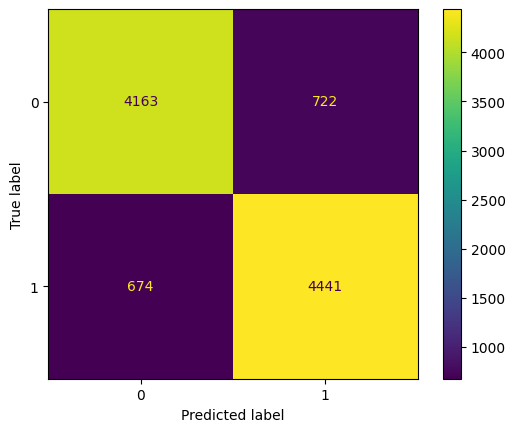

SVM accuracy: 0.8604
SVM f1: 0.8641759097100603


In [ ]:
SVM=svm.SVC(C=1.0,kernel="linear",degree=3,gamma="auto")
SVM.fit(trainX,trainY)
SVM_pred=SVM.predict(testX)
SVM_accuracy=accuracy_score(testY,SVM_pred)
SVM_f1=f1_score(testY,SVM_pred)
ConfusionMatrixDisplay.from_predictions(testY,SVM_pred)
plt.show()
print(f"SVM accuracy: {SVM_accuracy}")
print(f"SVM f1: {SVM_f1}")

## Logistic regression

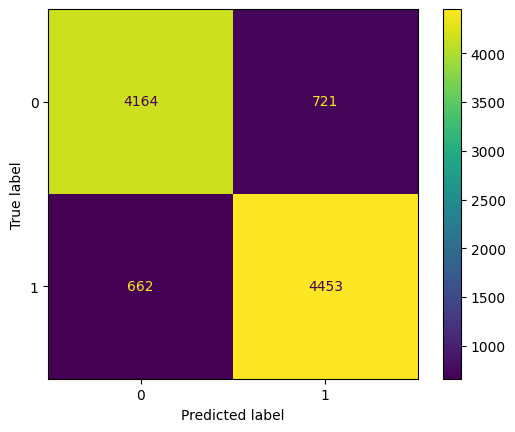

LR accuracy: 0.8617
LR f1: 0.8655846049178735


In [ ]:
LR=LogisticRegression()
LR.fit(trainX,trainY)
LR_pred=LR.predict(testX)
LR_accuracy=accuracy_score(testY,LR_pred)
LR_f1=f1_score(testY,LR_pred)
ConfusionMatrixDisplay.from_predictions(testY,LR_pred)
plt.show()
print(f"LR accuracy: {LR_accuracy}")
print(f"LR f1: {LR_f1}")

# Generic class for models

This will make training and testing a range of models with the same hyperperamaters and datasets easier. The `reshape` method is required because different models have different input shapes, and therefore the child class can simply override this method found in the parent class.

In [4]:
class Model():
    def __init__(self,model,loss_fn,optimizer,train_loader,test_loader,batch_size,epochs):
        self.model=model.to(device)
        self.loss_fn=loss_fn
        self.optimizer=optimizer
        self.train_loader=train_loader
        self.test_loader=test_loader
        self.batch_size=batch_size
        self.epochs=epochs

    def reshape(self,x):
        return x

    def pretrain(self):
        pass

    def postbatch(self):
        pass

    def train_loop(self):
        self.model.train()
        size=len(self.train_loader.dataset)
        self.pretrain()
        for batch,(x,y) in enumerate(self.train_loader):
            x,y=x.to(device),y.to(device)
            pred=self.model(self.reshape(x))
            cost=self.loss_fn(pred.flatten(),y)
            cost.backward()
            self.optimizer.step()
            self.optimizer.zero_grad()
            self.postbatch()
            if batch%10 == 0:
                cost,current=cost.item(),batch*self.batch_size+len(x)
                print(f"cost: {cost:>7f}  [{current:>5d}/{size:>5d}]")

    def test_loop(self):
        size=len(self.test_loader.dataset)
        num_batches=len(self.test_loader)
        correct=0

        preds=[]
        with torch.no_grad():
            for (x,y) in self.test_loader:
                x,y=x.to(device),y.to(device)
                pred=self.model(self.reshape(x)).flatten()
                preds.append(pred.to("cpu"))
                ncorrect=(torch.round(pred) == y).sum().item()
                correct+=ncorrect

        #print(correct,size)
        #print(f"Test Error: \n Accuracy: {(100*correct/size):>0.1f}%, Avg loss: {100*test_loss/size:>8f} \n")
        return 100*correct/size,np.hstack(preds)

    def train(self):
        self.model.eval()
        x=np.arange(self.epochs)
        y=np.zeros(self.epochs)
        preds=np.zeros((self.epochs,len(self.test_loader.dataset)))
        for epoch in range(self.epochs):
            self.train_loop()
            y[epoch],preds[epoch]=self.test_loop()
        plt.plot(x,y)
        plt.xlabel("epoch")
        plt.ylabel("Accuracy")
        plt.title("Accuracy vs epoch")
        i=np.argmax(y)
        print(f"Maximum accuracy (epoch {i+1}) = {y[i]:.4f}")
        f1=f1_score(self.test_loader.dataset.getlabel(),np.round(preds[i]))
        print(f"F1 score = {f1}")
        ConfusionMatrixDisplay.from_predictions(self.test_loader.dataset.getlabel(),np.round(preds[i]))
        plt.show()

In [5]:
class corpus(Dataset):
    def __init__(self,corpus,label):
        self.corpus=corpus
        self.label=label
    def __len__(self):
        return len(self.corpus)
    def __getitem__(self,idx):
        return self.corpus[idx],self.label[idx]
    def getlabel(self):
        return self.label

# CNN

In [38]:
class CNNClassifier(nn.Module):
    def __init__(self,n,kerns,pool_kerns,out_chans):
        super(CNNClassifier,self).__init__()
        self.kerns=kerns
        self.pool_kerns=pool_kerns
        self.convs=[]
        self.pools=[]
        self.stride=1
        self.n=n
        #self.embed=nn.Embedding(n,max_length)
        in_chan=1
        for i in range(len(kerns)):
            out_chan=out_chans[i]
            kern=kerns[i]
            pool_kern=pool_kerns[i]
            self.convs.append(nn.Conv1d(in_chan,out_chan,kern))
            self.compute_size(kern,self.stride)
            self.pools.append(nn.MaxPool1d(pool_kern))
            self.compute_size(pool_kern,pool_kern)
            in_chan=out_chan
        self.convs=nn.ModuleList(self.convs)
        self.pools=nn.ModuleList(self.pools)
        self.fc1=nn.Linear(self.n*out_chan,1)
        #self.fc2=nn.Linear(100,1)

    def compute_size(self,kernel,stride):
        self.n=(self.n-kernel)//stride+1
        return self.n

    def forward(self,x):
        #x=self.embed(x)
        for i in range(len(self.kerns)):
            x=nn.LeakyReLU()(self.convs[i](x))
            x=self.pools[i](x)
            x=nn.Dropout(0.2)(x)
        x=torch.flatten(x,1)
        #x=F.relu(self.fc1(x))
        #x=self.fc2(x)
        x=self.fc1(x)
        x=nn.Sigmoid()(x)
        return x

class CNNModel(Model):
    def reshape(self,x):
        return x.reshape(self.batch_size,1,x.shape[1])

In [7]:
trainX=torch.from_numpy(trainX.toarray()).float()
testX=torch.from_numpy(testX.toarray()).float()
trainY=torch.from_numpy(trainY).float()
testY=torch.from_numpy(testY).float()

In [42]:
train_loader=DataLoader(corpus(trainX,trainY),batch_size=batch_size)
test_loader=DataLoader(corpus(testX,testY),batch_size=batch_size)
cnn_classifier=CNNClassifier(trainX.shape[1],[2],[2],[3]).to(device)
cnn=CNNModel(cnn_classifier,nn.BCELoss(),Adam(cnn_classifier.parameters(),lr=lr),train_loader,test_loader,batch_size,epochs)

cost: 0.689977  [   50/24000]
cost: 0.702229  [  550/24000]
cost: 0.690762  [ 1050/24000]
cost: 0.693992  [ 1550/24000]
cost: 0.689228  [ 2050/24000]
cost: 0.692546  [ 2550/24000]
cost: 0.711083  [ 3050/24000]
cost: 0.692728  [ 3550/24000]
cost: 0.734323  [ 4050/24000]
cost: 0.760414  [ 4550/24000]
cost: 0.708677  [ 5050/24000]
cost: 0.709468  [ 5550/24000]
cost: 0.735290  [ 6050/24000]
cost: 0.703743  [ 6550/24000]
cost: 0.850857  [ 7050/24000]
cost: 0.696986  [ 7550/24000]
cost: 0.699833  [ 8050/24000]
cost: 0.687376  [ 8550/24000]
cost: 0.712796  [ 9050/24000]
cost: 0.675334  [ 9550/24000]
cost: 0.711168  [10050/24000]
cost: 0.679614  [10550/24000]
cost: 0.909469  [11050/24000]
cost: 0.698566  [11550/24000]
cost: 0.670077  [12050/24000]
cost: 0.682559  [12550/24000]
cost: 0.706765  [13050/24000]
cost: 0.736814  [13550/24000]
cost: 0.691577  [14050/24000]
cost: 0.673453  [14550/24000]
cost: 0.761146  [15050/24000]
cost: 0.763415  [15550/24000]
cost: 0.682958  [16050/24000]
cost: 0.70

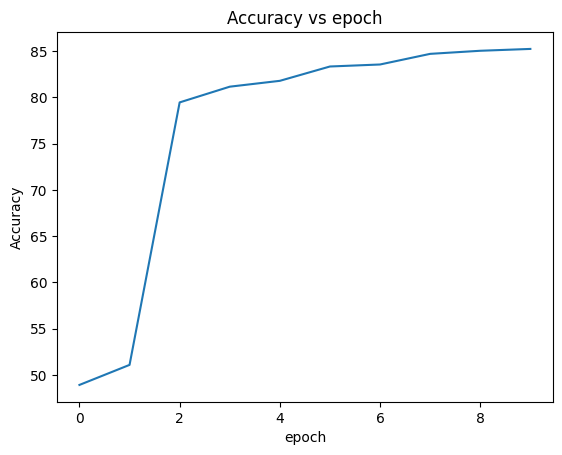

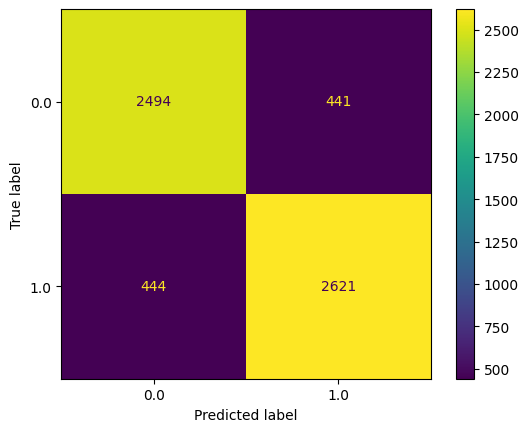

In [43]:
cnn.train()


# LSTM

In [6]:
class LSTMClassifier(nn.Module):
    def __init__(self,input_size,hidden_size,num_layers,dataX,dataY):
        super(LSTMClassifier,self).__init__()
        self.input_size=input_size
        self.hidden_size=hidden_size
        self.maxlen=0
        self.vectorizer=CountVectorizer()
        self.num_layers=num_layers
        self.dataY=dataY
        self.lstm=nn.LSTM(input_size,hidden_size,batch_first=True,num_layers=num_layers)
        self.vectorizer.fit(dataX)
        self.dataX=self.transform(dataX)
        self.trainX,self.testX,self.trainY,self.testY=model_selection.train_test_split(self.dataX,self.dataY,test_size=test_size)

        Encoder=LabelEncoder()
        self.trainY=torch.from_numpy(Encoder.fit_transform(self.trainY)).float()
        self.testY=torch.from_numpy(Encoder.fit_transform(self.testY)).float()

        self.fc=nn.Linear(self.hidden_size*self.maxlen,1)
        self.embed=self.embed_layer()

        self.hn=None
        self.cn=None

    def embed_layer(self):
        return nn.Embedding(len(self.vectorizer.vocabulary_),self.input_size)

    def get_vocab(self):
        return self.vectorizer.vocabulary_

    def in_vocab(self,token):
        return token in self.vectorizer.vocabulary_

    def get_index(self,token):
        return self.vectorizer.vocabulary_[token]

    def transform(self,text):
        vect=self.vectorizer
        d=self.get_vocab()
        p=vect.build_preprocessor()
        t=vect.build_tokenizer()
        vec_list=[]
        for doc in text:
            tokens=t(p(doc))
            s=len(tokens)
            if s>self.maxlen:
                self.maxlen=s
            doc_vec=np.array([self.get_index(token) for token in tokens if self.in_vocab(token)])
            vec_list.append(doc_vec)
        vec_list=sequence.pad_sequences(vec_list,maxlen=self.maxlen)
        corpus_vec=np.vstack(vec_list)
        return torch.tensor(corpus_vec)

    def forward(self,x):
        x=self.embed(x)
        if self.hn==None and self.cn==None:
            x, (self.hn,self.cn) = self.lstm(x)
        else:
            x, (self.hn,self.cn) = self.lstm(x,(self.hn,self.cn))
        #x = torch.flatten(x[:,-1,:],1)
        # Flatten like this so that all information from previous time steps is fed into fully connected layer
        x=torch.flatten(x,1)
        x=self.fc(x)
        return nn.Sigmoid()(x)

class LSTM(Model):
    def pretrain(self):
        self.model.hn=None
        self.model.cn=None

    def postbatch(self):
        self.model.hn=self.model.hn.detach()
        self.model.cn=self.model.cn.detach()

In [55]:
lstm_classifier=LSTMClassifier(LSTM_embed_dim,LSTM_hidden_dim,LSTM_num_layers,data["text"],data["label"])
LSTM_train_loader=DataLoader(corpus(lstm_classifier.trainX,lstm_classifier.trainY),batch_size=batch_size)
LSTM_test_loader=DataLoader(corpus(lstm_classifier.testX,lstm_classifier.testY),batch_size=batch_size)
lstm=LSTM(lstm_classifier,nn.BCELoss(),Adam(lstm_classifier.parameters(),lr=lr),LSTM_train_loader,LSTM_test_loader,batch_size,epochs)

cost: 0.695044  [   50/24000]
cost: 0.797777  [  550/24000]
cost: 0.686108  [ 1050/24000]
cost: 0.683294  [ 1550/24000]
cost: 0.682404  [ 2050/24000]
cost: 0.687737  [ 2550/24000]
cost: 0.689234  [ 3050/24000]
cost: 0.685684  [ 3550/24000]
cost: 0.667581  [ 4050/24000]
cost: 0.696894  [ 4550/24000]
cost: 0.698682  [ 5050/24000]
cost: 0.695667  [ 5550/24000]
cost: 0.679417  [ 6050/24000]
cost: 0.666670  [ 6550/24000]
cost: 0.659232  [ 7050/24000]
cost: 0.697948  [ 7550/24000]
cost: 0.689081  [ 8050/24000]
cost: 0.680593  [ 8550/24000]
cost: 0.684018  [ 9050/24000]
cost: 0.711046  [ 9550/24000]
cost: 0.681546  [10050/24000]
cost: 0.705374  [10550/24000]
cost: 0.679025  [11050/24000]
cost: 0.689056  [11550/24000]
cost: 0.685943  [12050/24000]
cost: 0.714148  [12550/24000]
cost: 0.696386  [13050/24000]
cost: 0.669452  [13550/24000]
cost: 0.677742  [14050/24000]
cost: 0.728189  [14550/24000]
cost: 0.676270  [15050/24000]
cost: 0.656276  [15550/24000]
cost: 0.678546  [16050/24000]
cost: 0.68

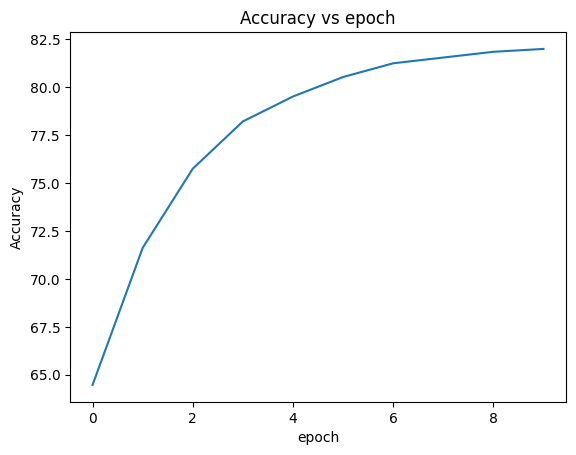

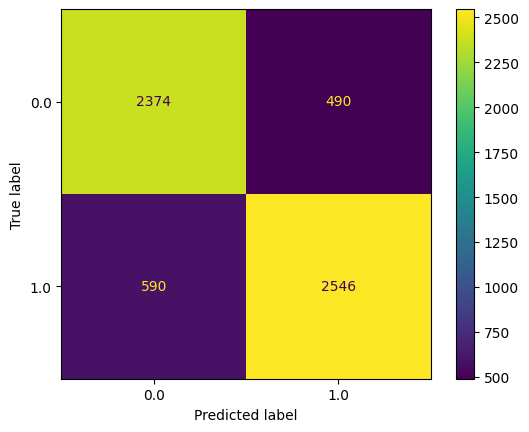

In [56]:
lstm.train()

# LSTM with pretrained embedding

## word2vec

In [22]:
from gensim.models.keyedvectors import KeyedVectors
word2vec_file="drive/MyDrive/Colab Notebooks/GoogleNews-vectors-negative300.bin.gz"

class LSTMClassifier_word2vec(LSTMClassifier):
    def __init__(self,input_size,hidden_size,num_layers,dataX,dataY):
        self.word2vec=KeyedVectors.load_word2vec_format("drive/MyDrive/Colab Notebooks/GoogleNews-vectors-negative300.bin.gz", binary=True, limit=20000)
        super(LSTMClassifier_word2vec,self).__init__(input_size,hidden_size,num_layers,dataX,dataY)

    def embed_layer(self):
        return nn.Embedding.from_pretrained(torch.from_numpy(self.word2vec.vectors),freeze=False)

    def get_vocab(self):
        return self.word2vec

    def in_vocab(self,token):
        return token in self.word2vec

    def get_index(self,token):
        return self.word2vec.get_index(token)

In [26]:
lstm_classifier_word2vec=LSTMClassifier_word2vec(word2vec_dim,LSTM_hidden_dim,LSTM_num_layers,data["text"],data["label"])
LSTM_train_loader_word2vec=DataLoader(corpus(lstm_classifier_word2vec.trainX,lstm_classifier_word2vec.trainY),batch_size=batch_size)
LSTM_test_loader_word2vec=DataLoader(corpus(lstm_classifier_word2vec.testX,lstm_classifier_word2vec.testY),batch_size=batch_size)
lstm_word2vec=LSTM(lstm_classifier_word2vec,nn.BCELoss(),Adam(lstm_classifier_word2vec.parameters(),lr=lr),LSTM_train_loader_word2vec,LSTM_test_loader_word2vec,batch_size,epochs)

cost: 0.692136  [   50/24000]
cost: 0.691143  [  550/24000]
cost: 0.684931  [ 1050/24000]
cost: 0.680192  [ 1550/24000]
cost: 0.673324  [ 2050/24000]
cost: 0.652294  [ 2550/24000]
cost: 0.663098  [ 3050/24000]
cost: 0.635651  [ 3550/24000]
cost: 0.648262  [ 4050/24000]
cost: 0.661522  [ 4550/24000]
cost: 0.473013  [ 5050/24000]
cost: 0.438624  [ 5550/24000]
cost: 0.400700  [ 6050/24000]
cost: 0.368152  [ 6550/24000]
cost: 0.350941  [ 7050/24000]
cost: 0.357929  [ 7550/24000]
cost: 0.417204  [ 8050/24000]
cost: 0.667990  [ 8550/24000]
cost: 0.351769  [ 9050/24000]
cost: 0.377289  [ 9550/24000]
cost: 0.353716  [10050/24000]
cost: 0.335918  [10550/24000]
cost: 0.328098  [11050/24000]
cost: 0.181036  [11550/24000]
cost: 0.392215  [12050/24000]
cost: 0.450330  [12550/24000]
cost: 0.458121  [13050/24000]
cost: 0.482923  [13550/24000]
cost: 0.416370  [14050/24000]
cost: 0.343861  [14550/24000]
cost: 0.269932  [15050/24000]
cost: 0.282686  [15550/24000]
cost: 0.293767  [16050/24000]
cost: 0.33

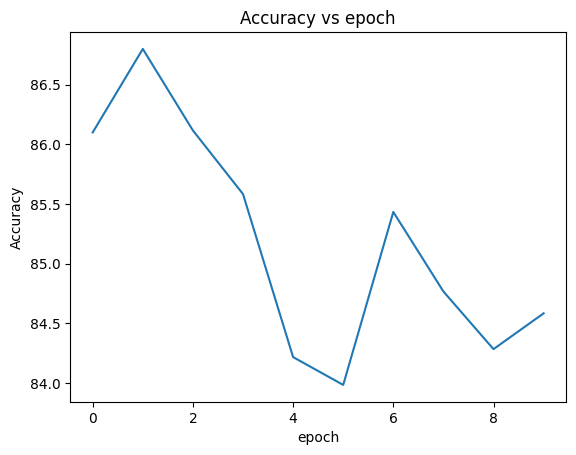

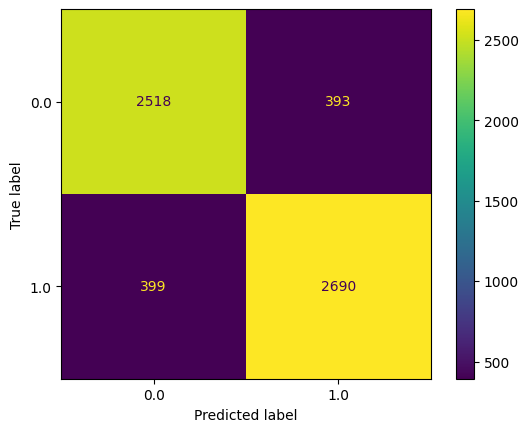

In [27]:
lstm_word2vec.train()

## GloVe

In [31]:
glove_file="drive/MyDrive/Colab Notebooks/glove.6B/glove.6B.100d.txt"

class LSTMClassifier_glove(LSTMClassifier):
    def __init__(self,input_size,hidden_size,num_layers,dataX,dataY):
        glove_data_f=np.genfromtxt(glove_file,dtype=float,invalid_raise=False)
        glove_data_s=np.genfromtxt(glove_file,dtype=str,usecols=0,invalid_raise=False)
        glove_vocab=dict(zip(glove_data_s,[x for x in range(1,len(glove_data_s)+1)]))
        dummy_vec=np.zeros(glove_dim)
        glove_vocab["</s>"]=0
        glove_data_f=np.vstack((dummy_vec,glove_data_f[:,1:]))
        self.glove=glove_data_f
        super().__init__(input_size,hidden_size,num_layers,dataX,dataY)

    def embed_layer(self):
        return nn.Embedding.from_pretrained(torch.tensor(self.glove).float(),freeze=False)

    def get_vocab(self):
        return self.glove

    def in_vocab(self,token):
        return token in self.glove

    def get_index(self,token):
        return self.glove[token]

In [ ]:
lstm_classifier_glove=LSTMClassifier_glove(glove_dim,LSTM_hidden_dim,LSTM_num_layers,data["text"],data["label"])
LSTM_train_loader_glove=DataLoader(corpus(lstm_classifier_glove.trainX,lstm_classifier_glove.trainY),batch_size=batch_size)
LSTM_test_loader_glove=DataLoader(corpus(lstm_classifier_glove.testX,lstm_classifier_glove.testY),batch_size=batch_size)
lstm_glove=LSTM(lstm_classifier_glove,nn.BCELoss(),Adam(lstm_classifier_glove.parameters(),lr=lr),LSTM_train_loader_glove,LSTM_test_loader_glove,batch_size,epochs)

/tmp/ipython-input-31-36799222.py:5: ConversionWarning: Some errors were detected !
    Line #248458 (got 1 columns instead of 101)
    Line #254064 (got 1 columns instead of 101)
    Line #333494 (got 1 columns instead of 101)
    Line #377299 (got 1 columns instead of 101)
  glove_data_f=np.genfromtxt(glove_file,dtype=float,invalid_raise=False)


# New Section